# 만들고자 하는 것 : HR Analytics: Job Change of Data Scientists의 Feature 분석
---
# 필요한 기능들 
1. HR Analytics: Job Change of Data Scientists 데이터셋 로드 
2. 데이터전처리 
  - 데이터셋을 분석(EDA)
  - 데이터셋 클린징(결측치, 중복데이터, 왜도/첨도)
  - 학습에 도움이되는 feature 생성 
  - 범주형 데이터를 숫자형 데이터로 변환 
  - 숫자 데이터의 범위를 통일(scaling)
  - (옵션) unbalance dataset인 경우, 처리 필요
3. 모델링 
  - 모델 생성
  - 하이퍼 파라미터 튜닝 
  - cross validation 진행 
4. 평가 
  - underfitting / overfitting 
  - matrix(평가지표)를 이용해서 점수 확인 

# 1. HR Analytics: Job Change of Data Scientists 데이터셋 로드하기

In [1]:
#필요한 패키지 다운로드
import pandas as pd
from pathlib import Path

In [7]:
#데이터 경로 지정
DATA_PATH = Path("./Data")
train_path = DATA_PATH/"aug_train.csv"
test_path = DATA_PATH/"aug_test.csv"
submission_path = DATA_PATH/"sample_submission.csv"


# 2. 데이터 전처리

## 2-1. EDA

In [8]:
#pandas로 파일 읽기
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_submission = pd.read_csv(submission_path)

In [12]:
df_train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [15]:
df_train.shape

(19158, 14)

In [19]:
df_test.shape

(2129, 13)

In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [20]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             2129 non-null   int64  
 1   city                    2129 non-null   object 
 2   city_development_index  2129 non-null   float64
 3   gender                  1621 non-null   object 
 4   relevent_experience     2129 non-null   object 
 5   enrolled_university     2098 non-null   object 
 6   education_level         2077 non-null   object 
 7   major_discipline        1817 non-null   object 
 8   experience              2124 non-null   object 
 9   company_size            1507 non-null   object 
 10  company_type            1495 non-null   object 
 11  last_new_job            2089 non-null   object 
 12  training_hours          2129 non-null   int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 216.4+ KB


test와 train의 컬럼수가 일치하지 않음. train의 target컬럼을 drop해야함

In [17]:
df_train.isnull().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

**EDA 결과**
1. train 데이터에서 target컬럼 삭제할 필요 있어보임
2. 결측치 처리방안
	- gender (23% 결측) → drop보다는 "Unknown" 추가 추천
	- major_discipline (15% 결측) → "Unknown" 범주 추가
	- company_size (31% 결측), company_type (32% 결측) → 결측률 높음 → 두 가지 전략
		1. "Unknown" 범주 추가 (정보 보존)
		2. feature importance 확인 후 성능에 기여 안 하면 drop
	- education_level, last_new_job, experience → 결측 적음 → 최빈값(mode)로 대체

## 2-2. Data Cleansing

1. train데이터에서 target컬럼을 삭제함

In [21]:
#우선 target컬럼을 x와 y로 쪼개자
X_train = df_train.drop("target", axis=1)
y_train = df_train["target"]

2. 결측치 처리하자
---
- gender (23% 결측) → drop보다는 "Unknown" 추가 추천
- major_discipline (15% 결측) → "Unknown" 범주 추가
- company_size (31% 결측), company_type (32% 결측) → 결측률 높음 → 두 가지 전략
    1. "Unknown" 범주 추가 (정보 보존)
    2. feature importance 확인 후 성능에 기여 안 하면 drop
- education_level, last_new_job, experience → 결측 적음 → 최빈값(mode)로 대체

In [25]:
X_train.isnull().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
dtype: int64

In [33]:
#범주형 데이터 중 Unkown으로 처리하는 컬럼들
for col in ['gender', 'major_discipline', 'company_size', 'company_type']:
    X_train[col] = X_train[col].fillna("Unknown")

#범주형 데이터 중 최빈값으로 처리하는 컬럼들
for col in ['education_level', 'last_new_job', 'experience']:
    X_train[col] = X_train[col].fillna(X_train[col].mode()[0])

In [37]:
#결측치 잘 채워졌는지 한 번 확인
X_train['education_level'].value_counts(), X_train['gender'].value_counts()

(education_level
 Graduate          12058
 Masters            4361
 High School        2017
 Phd                 414
 Primary School      308
 Name: count, dtype: int64,
 gender
 Male       13221
 Unknown     4508
 Female      1238
 Other        191
 Name: count, dtype: int64)

## 2-3. One-Hot Encoding

In [39]:
#원핫인코딩 진행
X_train_encoded = pd.get_dummies(X_train, drop_first=False)

print("원핫인코딩 하기 전:", X_train.shape)
print("----------------------------")
print("원한인코딩 하고 나서:", X_train_encoded.shape)
print("----------------------------")
print(X_train_encoded.head())

원핫인코딩 하기 전: (19158, 13)
----------------------------
원한인코딩 하고 나서: (19158, 191)
----------------------------
   enrollee_id  city_development_index  training_hours  city_city_1  \
0         8949                   0.920              36        False   
1        29725                   0.776              47        False   
2        11561                   0.624              83        False   
3        33241                   0.789              52        False   
4          666                   0.767               8        False   

   city_city_10  city_city_100  city_city_101  city_city_102  city_city_103  \
0         False          False          False          False           True   
1         False          False          False          False          False   
2         False          False          False          False          False   
3         False          False          False          False          False   
4         False          False          False          False          

## 2-4. Feature에 대해서 Heatmap 그리기

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#히트맵 그리기 전에 컬럼 합치고 정리
df_corr = pd.concat([X_train_encoded, y_train], axis=1)

corr_matrix = df_corr.corr()

corr_with_target = corr_matrix[['target']].sort_values(by='target', ascending=False)
# .sort_values -> 정렬 메서드
# by='target' -> 타겟컬럼을 기준으로 정렬한다.
# ascending=False -> 내림차순 정렬(큰거에서 작은거로)

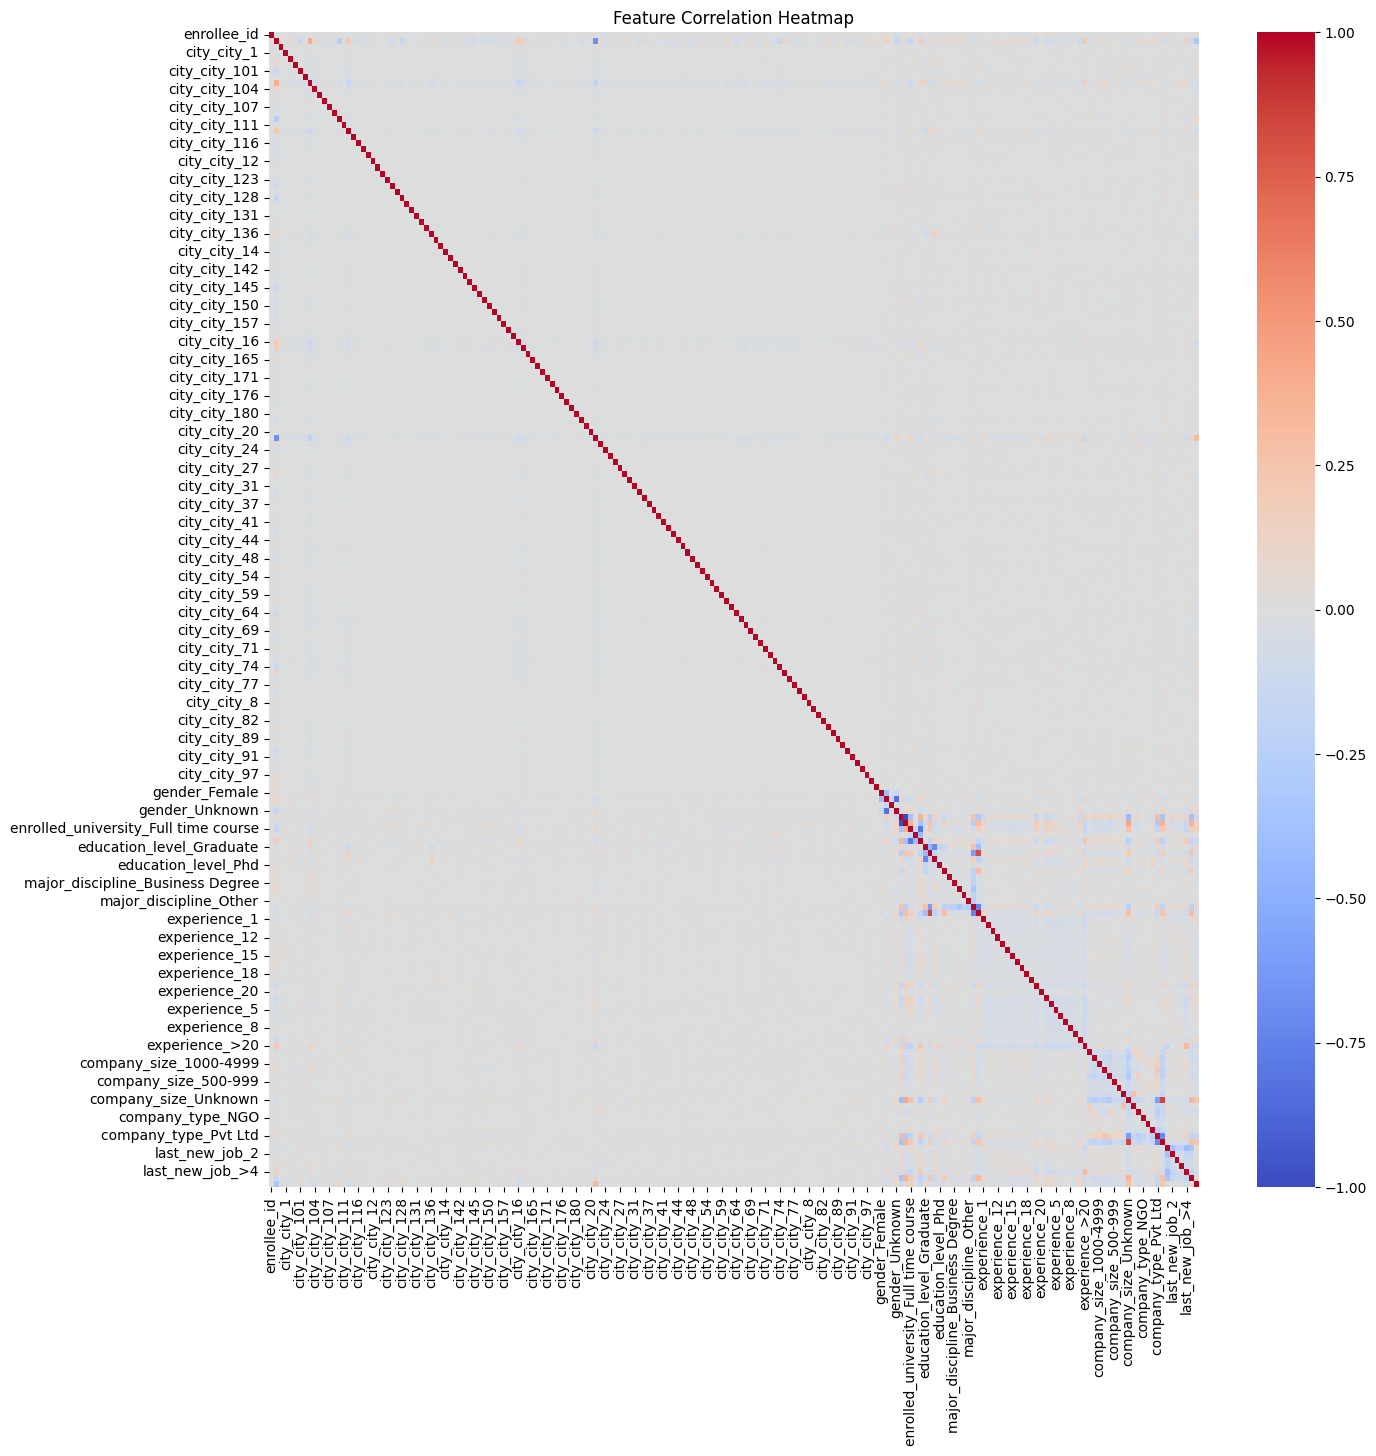

In [43]:
plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

위의 문제는 원핫인코딩을 진행하면서 컬럼들이 무지막지하게 많이 생겼는데 그걸 다 heatmap으로 그리니까 사람이 알아보기 어려운 문제가 생겼다.  

따라서 이 문제를 해결하기 위해서는 target과의 상관계수가 높은 것들만 뽑아서 보는게 그래프 분석에 용이하다

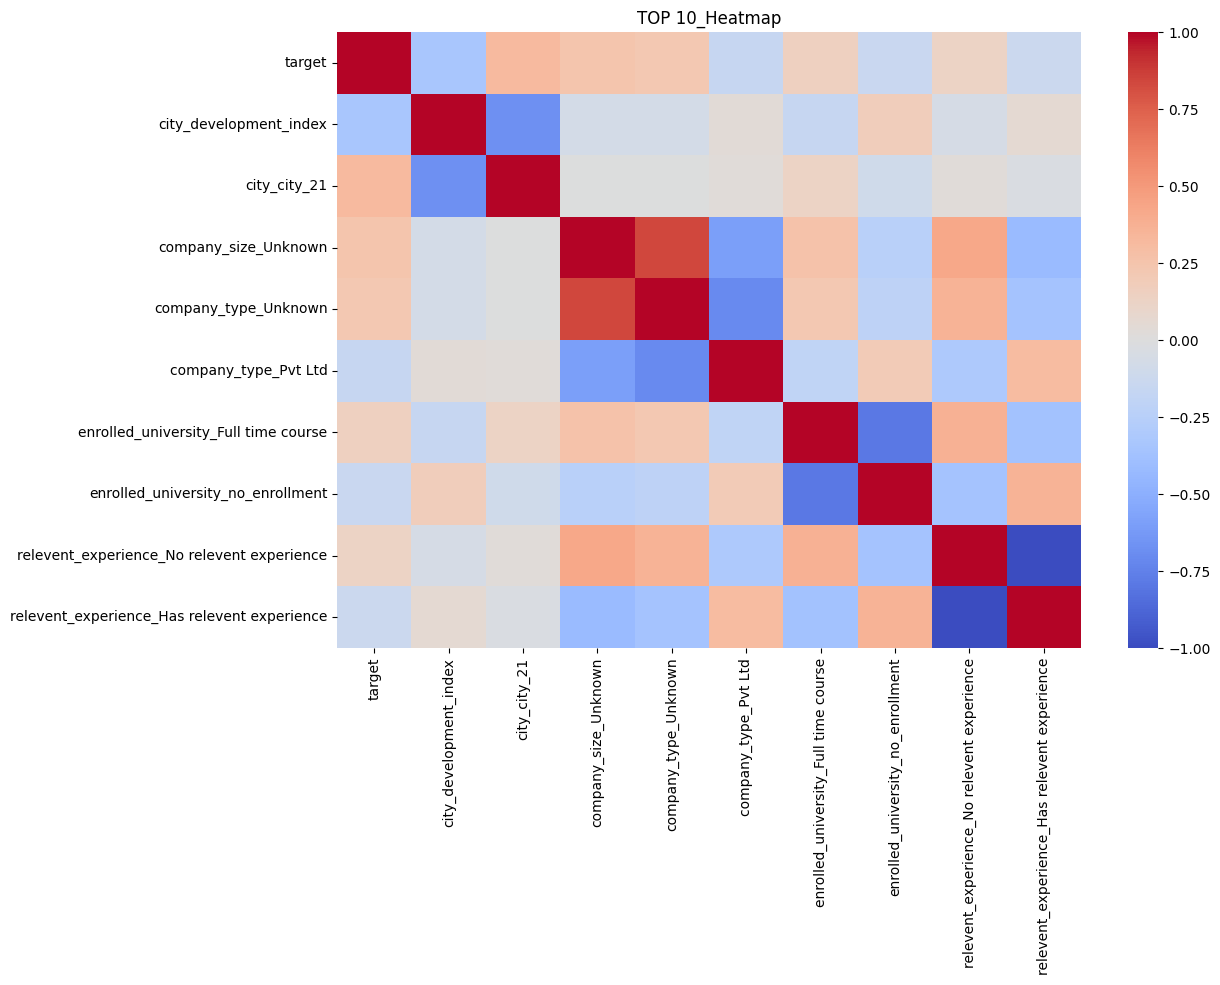

In [47]:
top_features = corr_with_target.abs().sort_values(by='target', ascending=False).head(10).index
#상관계수의 절댓값 기준으로 상위 20개만 뽑음.

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix.loc[top_features, top_features], cmap='coolwarm', annot=False)
plt.title("TOP 10_Heatmap")
plt.show()

In [48]:
print(corr_with_target.head(10))  # 상위 10개 상관계수 값 출력

                                              target
target                                      1.000000
city_city_21                                0.320036
company_size_Unknown                        0.242456
company_type_Unknown                        0.220533
enrolled_university_Full time course        0.150171
relevent_experience_No relevent experience  0.128430
city_city_11                                0.091345
education_level_Graduate                    0.085527
experience_<1                               0.079178
gender_Unknown                              0.075356
